In [19]:
# ZZ_scratch.ipynb - This is a general scratchpad used for code development and testing. Don't expect it to work as written
# Eric G. Suchanek, PhD. 2024

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pyvista as pv
import logging

import os
import pandas as pd
import numpy as np
from proteusPy.logger_config import (
    list_all_loggers,
    set_logger_level,
    toggle_stream_handler,
    configure_master_logger,
    list_handlers,
    disable_stream_handlers_for_namespace,
    set_logging_level_for_all_handlers,
)


from proteusPy import (
    Load_PDB_SS,
    Disulfide,
    DisulfideList,
    DisulfideLoader,
    torsion_to_class_string,
    Bootstrap_PDB_SS,
    load_disulfides_from_id,
    create_logger,
    configure_master_logger,
    Vector3D,
)

from proteusPy.atoms import (
    ATOM_COLORS,
    ATOM_RADII_COVALENT,
    ATOM_RADII_CPK,
    BOND_COLOR,
    BOND_RADIUS,
    BS_SCALE,
    FONTSIZE,
    SPEC_POWER,
    SPECULARITY,
)

from proteusPy.ProteusGlobals import *

HOME = Path.home()
PDB = Path(os.getenv("PDB", HOME / "pdb"))

MODEL_DIR = PDB / "good"

PDB_DATA_DIR = PDB / "data"
SAVE_DIR = HOME / "Documents" / "proteusPyDocs" / "classes"
REPO_DIR = HOME / "repos" / "proteusPy" / "data"

OCTANT = SAVE_DIR / "octant"
OCTANT.mkdir(parents=True, exist_ok=True)

BINARY = SAVE_DIR / "binary"
BINARY.mkdir(parents=True, exist_ok=True)

SEXTANT = SAVE_DIR / "sextant"
SEXTANT.mkdir(parents=True, exist_ok=True)

PBAR_COLS = 78
configure_master_logger("fafo.log")

In [2]:
# disable_stream_handlers_for_namespace("proteusPy")
pdb = Load_PDB_SS(verbose=True, subset=False, cutoff=-1.0, force=False)
pdb.describe()

-> load_PDB_SS(): Reading /Users/egs/miniforge3/envs/ppydev/lib/python3.11/site-packages/proteusPy/data/PDB_SS_ALL_LOADER.pkl... 
-> load_PDB_SS(): Done Reading /Users/egs/miniforge3/envs/ppydev/lib/python3.11/site-packages/proteusPy/data/PDB_SS_ALL_LOADER.pkl... 
    =========== RCSB Disulfide Database Summary ==============
       =========== Built: 2024-11-13 09:16:51 ==============
PDB IDs present:                    36968
Disulfides loaded:                  175277
Average structure resolution:       2.19 Å
Lowest Energy Disulfide:            2q7q_75D_140D
Highest Energy Disulfide:           6vxk_801B_806B
Cα distance cutoff:                 -1.00 Å
Total RAM Used:                     44.26 GB.
    ================= proteusPy: 0.97.16.dev0 =======================


In [3]:
pdb["2q7q_75D_140D"]

<Disulfide 2q7q_75D_140D, Source: 2q7q, Resolution: 1.0 Å>

In [4]:
pdb.SSDict.get("xxx")

In [5]:
pdb['2q7q_75D_140D']

<Disulfide 2q7q_75D_140D, Source: 2q7q, Resolution: 1.0 Å>

In [6]:
pdb.get_by_name("2q7q_75D_140D")

<Disulfide 2q7q_75D_140D, Source: 2q7q, Resolution: 1.0 Å>

In [11]:
ind = pdb.SSDict.get("2q7q_75D")
ind

In [7]:
def get_pdbid_with_max_disulfides(PDB_SS):
    """
    Enumerates PDB_SS.SSDict and returns the pdbid for the key with the largest number of disulfides.

    Args:
        PDB_SS (object): The object containing the SSDict attribute.

    Returns:
        str: The pdbid with the largest number of disulfides.
    """
    max_disulfides = 0
    pdbid_with_max_disulfides = None

    for pdbid, disulfides in PDB_SS.SSDict.items():
        num_disulfides = len(disulfides)
        if num_disulfides > max_disulfides:
            max_disulfides = num_disulfides
            pdbid_with_max_disulfides = pdbid

    return pdbid_with_max_disulfides, max_disulfides

In [8]:
get_pdbid_with_max_disulfides(pdb)

('7nyc', 93)

In [ ]:
big = pdb["7nyc"]

In [16]:
import matplotlib.pyplot as plt


def plot_disulfides_vs_pdbid(PDB_SS, cutoff=1):
    """
    Plots the number of disulfides versus pdbid.

    Args:
        PDB_SS (object): The object containing the SSDict attribute.
    """
    pdbids = []
    num_disulfides = []

    for pdbid, disulfides in PDB_SS.SSDict.items():
        if len(disulfides) > cutoff:
            pdbids.append(pdbid)
            num_disulfides.append(len(disulfides))

    plt.figure(figsize=(12, 6))
    plt.bar(pdbids, num_disulfides, color="skyblue")
    plt.xlabel("PDB ID")
    plt.ylabel("Number of Disulfides")
    plt.title(f"Number of Disulfides vs PDB ID with cutoff: {cutoff}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    return pdbids, num_disulfides

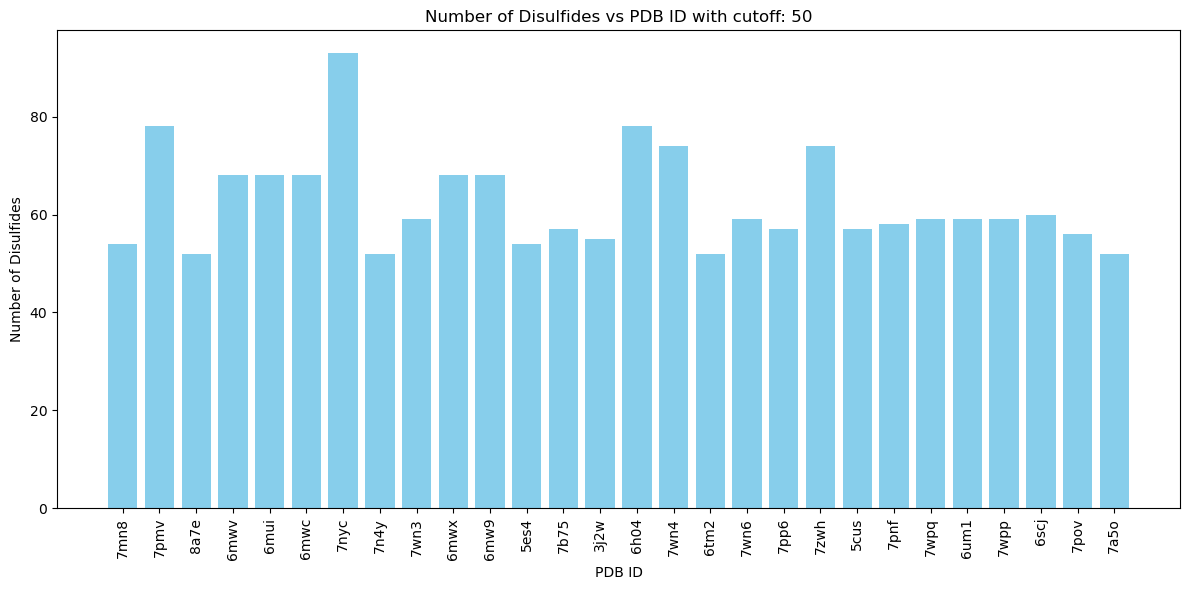

In [20]:
pdbids, num_disulfides = plot_disulfides_vs_pdbid(pdb, cutoff=50)

In [ ]:
colors = [
    ["ff0000", "28e5da", "0000ff"],
    ["ffff00", "c8bebe", "f79292"],
    ["fffff0", "f18c1d", "23dcaa"],
    ["d785ec", "9d5b13", "e4e0b1"],
    ["894509", "af45f5", "fff000"],
]


class SetVisibilityCallback:
    """Helper callback to keep a reference to the actor being modified."""

    def __init__(self, actor):
        self.actor = actor

    def __call__(self, state):
        self.actor.SetVisibility(state)


# Widget size
import pyvista as pv

size = 50

p = pv.Plotter()

Startpos = 12
for i, lst in enumerate(colors):
    for j, color in enumerate(lst):
        actor = p.add_mesh(pv.Sphere(center=(i, j, 0)), color=color)
        # Make a separate callback for each widget
        callback = SetVisibilityCallback(actor)
        p.add_checkbox_button_widget(
            callback,
            value=True,
            position=(5.0, Startpos),
            size=size,
            border_size=1,
            color_on=color,
            color_off="grey",
            background_color="grey",
        )
        Startpos = Startpos + size + (size // 10)

p.show()

In [ ]:
ss1 = pdb[0]
# ss1.pprint_all()
cofmass = ss1.coord_cofmass

In [ ]:
ss1.translate(Vector3D(-cofmass))
ss1.pprint_all()

In [ ]:
crn1 = pdb["1crn"]
crn1.pprint_all()
cofmass = crn1.center_of_mass
cofmass

In [ ]:
crn1.translate(Vector3D(-cofmass))
print(f"Center of mass is {cofmass}")
crn1.pprint_all()

In [ ]:
sslist.build_distance_df()

In [ ]:
sslist.average_torsion_distance

In [ ]:
sslist.display_overlay()

In [ ]:
sslist = load_disulfides_from_id("1tgk", pdb_dir=MODEL_DIR)
sslist

In [ ]:
sslist.average_energy

In [ ]:
sslist.average_conformation

In [ ]:
pdb["1tgk"]

In [8]:
sslist = pdb["4yys"]

In [ ]:
sslist = pdb.build_ss_from_idlist(["5rsa", "4yys", "2q7q"])
sslist

In [23]:
ss = pdb["2q7q_75D_140D"]

In [ ]:
neighbors = pdb.SSList.nearest_neighbors_ss(ss, 3)
neighbors

In [ ]:
neighbors2 = pdb.SSList.nearest_neighbors(5, [-60, -60, -83, -60, -60])
neighbors2.describe()
neighbors2.display_overlay()

In [ ]:
neighbors3 = pdb.SSList.nearest_neighbors(3.5, list(ss.dihedrals))
neighbors3

In [ ]:
sslist2 = pdb.SSList[:1000]
df = sslist2.create_deviation_dataframe()

In [ ]:
df.describe()

In [ ]:
ss.display()

In [ ]:
ss1 = pdb[0]
ss1.display(light="Auto", winsize=(800, 800))

In [ ]:
pp.get_theme()

In [ ]:
ss1 = pdb[0]
type(ss1)

In [ ]:
ss1.display(style="sb", light=False)

In [3]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
from proteusPy import Disulfide


def add_to_list(n, pdb_sslist):
    disulfide_list = []
    for i in range(n):
        disulfide_list.append(pdb_sslist[i])

    sslist = DisulfideList(disulfide_list, "tmp")
    avg = sslist.average_conformation


def add_to_ndarray(n, pdb_sslist):
    disulfide_array = np.empty(n, dtype=object)
    for i in range(n):
        disulfide_array[i] = pdb_sslist[i]
    sslist = DisulfideList(disulfide_array, "tmp")
    avg = sslist.average_conformation


def profile_sslist(sslist):
    # Number of objects to add
    num_objects = [1000, 5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000]

    # Measure time for adding to list
    list_times = []
    for n in num_objects:
        time = timeit.timeit(lambda: add_to_list(n, sslist), number=10)
        list_times.append(time)

    # Measure time for adding to ndarray
    ndarray_times = []
    for n in num_objects:
        time = timeit.timeit(lambda: add_to_ndarray(n, sslist), number=10)
        ndarray_times.append(time)

    # Plot the results
    plt.plot(num_objects, list_times, label="DisulfideList (list)")
    plt.plot(num_objects, ndarray_times, label="ndarray")
    plt.xlabel("Number of Disulfide Objects")
    plt.ylabel("Time (seconds)")
    plt.title("Comparison of Adding Disulfide Objects to List vs. ndarray")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
profile_sslist(pdb.SSList)

In [ ]:
tors_df2 = ss1.torsion_df
tors_df2.describe()

In [ ]:
pdb = DisulfideLoader(verbose=True, subset=True, cutoff=8.0)

In [ ]:
pdb = Load_PDB_SS(verbose=True, subset=False, cutoff=8.0)

In [ ]:
pdb[0]

In [ ]:
PDB_SS = Load_PDB_SS(subset=False, verbose=True)
PDB_SS.describe()

In [ ]:
import os
from pathlib import Path
import importlib.resources as pkg_resources

# Determine the base directory of the installed package
this_dir = Path(pkg_resources.files("proteusPy"))
this_dir

In [ ]:
ss1 = PDB_SS[0]
ss1.rho

In [5]:
from proteusPy import (
    torsion_to_sixclass,
    torsion_to_eightclass,
    torsion_to_class_string,
)

lhs = [-60, -60, -90, -60, -60]
rhs = [60, 60, 90, 60, 60]
six = torsion_to_sixclass(lhs)
eight = torsion_to_eightclass(lhs)

In [ ]:
cls = torsion_to_class_string(lhs, base=6)
cls

In [ ]:
six

In [ ]:
eight

In [9]:
sixr = torsion_to_sixclass(rhs)
eightr = torsion_to_eightclass(rhs)

In [ ]:
sixr

In [ ]:
eightr

In [ ]:
torsion_to_class_string(lhs, 6)

In [ ]:
torsion_to_class_string(lhs, 8)

In [ ]:
def plot_disulfide_secondary_structures(pdb_ss):
    """
    Plot a graph of disulfide secondary structures segmented by secondary structure.

    :param pdb_ss: The PDB_SS object containing SSList with disulfide bonds.
    :type pdb_ss: object
    """
    # Initialize counters for each secondary structure type
    helix_count = 0
    sheet_count = 0
    turn_count = 0
    nosecondary_count = 0

    # Iterate through the SSList and count the secondary structures
    for ss in pdb_ss.SSList:
        proximal_secondary = ss.proximal_secondary
        distal_secondary = ss.distal_secondary

        if proximal_secondary == "helix":
            helix_count += 1
        elif proximal_secondary == "sheet":
            sheet_count += 1
        elif proximal_secondary == "turn":
            turn_count += 1
        elif proximal_secondary == "nosecondary":
            nosecondary_count += 1

        if distal_secondary == "helix":
            helix_count += 1
        elif distal_secondary == "sheet":
            sheet_count += 1
        elif distal_secondary == "turn":
            turn_count += 1
        elif distal_secondary == "nosecondary":
            nosecondary_count += 1

    # Data for plotting
    labels = ["Helix", "Sheet", "Turn", "No Secondary"]
    counts = [helix_count, sheet_count, turn_count, nosecondary_count]

    # Plotting the data
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color=["blue", "green", "red", "gray"])
    plt.xlabel("Secondary Structure")
    plt.ylabel("Count of Disulfide Bonds")
    plt.title("Disulfide Bonds Segmented by Secondary Structure")
    plt.show()


import matplotlib.pyplot as plt


def plot_disulfide_secondary_structure_cooccurrence(pdb_ss):
    """
    Plot a graph of disulfide secondary structure co-occurrence by proximal-distal type.

    :param pdb_ss: The PDB_SS object containing SSList with disulfide bonds.
    :type pdb_ss: object
    """
    # Initialize counters for each proximal-distal secondary structure combination
    cooccurrence_counts = {}
    skipped = 0
    turns = 0
    cnt = 0

    # Iterate through the SSList and count the secondary structure combinations
    for ss in pdb_ss.SSList:
        proximal_secondary = ss.proximal_secondary
        distal_secondary = ss.distal_secondary
        # Skip disulfide bonds with no secondary structure or with a turn secondary structure

        if proximal_secondary == "nosecondary" or distal_secondary == "nosecondary":
            skipped += 1
            continue

        if proximal_secondary == "turn" or distal_secondary == "turn":
            turns += 1
            continue

        key = (proximal_secondary, distal_secondary)

        if key in cooccurrence_counts:
            cooccurrence_counts[key] += 1
        else:
            cooccurrence_counts[key] = 1

        cnt += 1

    print(
        f"Skipped {skipped} disulfide bonds with no secondary structure and {turns} turn secondary structure.\n"
        f"Disulfides used: {cnt}"
    )

    # Data for plotting
    labels = [f"{prox}-{dist}" for prox, dist in cooccurrence_counts.keys()]
    counts = list(cooccurrence_counts.values())

    # Plotting the data
    plt.figure(figsize=(12, 8))
    plt.bar(labels, counts, color="skyblue")
    plt.xlabel("Proximal-Distal Secondary Structure")
    plt.ylabel("Count of Disulfide Bonds")
    plt.title("Co-occurrence of Secondary Structures by Proximal-Distal Type")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_disulfide_secondary_structure_and_rho(pdb_ss):
    """
    Plot a graph of disulfide secondary structure co-occurrence by proximal-distal type
    and the disulfide parameter rho with error bars.

    :param pdb_ss: The PDB_SS object containing SSList with disulfide bonds.
    :type pdb_ss: object
    """
    # Initialize data structures for secondary structure combinations and rho values
    cooccurrence_counts = {}
    rho_values = {}

    # Iterate through the SSList and collect data
    for ss in pdb_ss.SSList:
        proximal_secondary = ss.proximal_secondary.strip().lower()
        distal_secondary = ss.distal_secondary.strip().lower()

        # Skip disulfide bonds with no secondary structure or with a turn secondary structure
        if proximal_secondary == "no_secondary" or distal_secondary == "no_secondary":
            continue

        if proximal_secondary == "turn" or distal_secondary == "turn":
            continue

        key = (proximal_secondary, distal_secondary)

        if key in cooccurrence_counts:
            cooccurrence_counts[key] += 1
            rho_values[key].append(ss.ca_distance)
        else:
            cooccurrence_counts[key] = 1
            rho_values[key] = [ss.rho]

    # Data for plotting
    labels = [f"{prox}-{dist}" for prox, dist in cooccurrence_counts.keys()]
    counts = list(cooccurrence_counts.values())
    rho_means = [np.mean(rho_values[key]) for key in rho_values.keys()]
    rho_stds = [np.std(rho_values[key]) for key in rho_values.keys()]

    # Plotting the secondary structure co-occurrence
    plt.figure(figsize=(12, 8))
    plt.bar(labels, counts, color="skyblue")
    plt.xlabel("Proximal-Distal Secondary Structure")
    plt.ylabel("Count of Disulfide Bonds")
    plt.title("Co-occurrence of Secondary Structures by Proximal-Distal Type")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Plotting the rho values with error bars
    plt.figure(figsize=(12, 8))
    plt.errorbar(
        labels,
        rho_means,
        yerr=rho_stds,
        fmt="o",
        color="red",
        ecolor="black",
        capsize=5,
    )
    plt.xlabel("Proximal-Distal Secondary Structure")
    plt.ylabel("Mean Rho Value")
    plt.title("Mean Rho Value by Proximal-Distal Secondary Structure with Error Bars")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [ ]:
plot_disulfide_secondary_structure_and_rho(PDB_SS)

In [ ]:
plot_disulfide_secondary_structures(PDB_SS)

In [ ]:
plot_disulfide_secondary_structure_cooccurrence(PDB_SS)

In [ ]:
from proteusPy import extract_ssbonds_and_atoms
from pathlib import Path
import os

verbose = True
structure_fname = str(MODEL_DIR / "pdb5rsa.ent")
ssbond_atom_list, num_ssbonds, errors = extract_ssbonds_and_atoms(
    structure_fname, verbose=verbose
)

In [ ]:
ssbond_atom_list["helices"]

In [ ]:
ssbond_atom_list["sheets"]

In [ ]:
ssbond_atom_list["turns"]

In [ ]:
ssbond_atom_list["ssbonds"]

In [ ]:
ssbond_atom_list["pairs"]

In [ ]:
ssbond_atom_list["pairs"]

In [ ]:
df = pd.DataFrame()
fig = PDB_SS.plot_count_vs_class_df(
    df,
    title="Binary",
    save=True,
    savedir=BINARY,
    verbose=True,
    base=2,
)
fig.show()

In [ ]:
PDB_SS.plot_binary_to_eightclass_incidence(
    theme="light", save=True, verbose=True, savedir=OCTANT
)

In [ ]:
PDB_SS.plot_binary_to_sixclass_incidence(
    theme="light", save=True, verbose=True, savedir=SEXTANT
)

In [ ]:
clslist6 = PDB_SS.tclass.sslist_from_classid("55555", base=6)
clslist6

In [ ]:
clslist8 = PDB_SS.tclass.sslist_from_classid("77778", base=8)
clslist8

In [ ]:
df2 = PDB_SS.tclass.classdf
df6 = PDB_SS.tclass.sixclass_df
df8 = PDB_SS.tclass.eightclass_df

In [ ]:
df2.head(32)

In [ ]:
df8

In [ ]:
df6

In [ ]:
def enumerate_class_fromlist(loader: DisulfideLoader, sslist):
    import pandas as pd

    x = []
    y = []

    for cls in sslist:
        if cls is not None:
            _y = loader.tclass.sslist_from_classid(cls)
            # it's possible to have 0 SS in a class
            if _y is not None:
                # only append if we have both.
                x.append(cls)
                y.append(len(_y))

    sslist_df = pd.DataFrame(columns=["class_id", "count"])
    sslist_df["class_id"] = x
    sslist_df["count"] = y
    return sslist_df

In [ ]:
cls = "00000"
sixcls = PDB_SS.tclass.binary_to_six_class(cls)
df = enumerate_class_fromlist(PDB_SS, sixcls)
# Assuming 'count' is the column by which we want to sort
sorted_df = df.sort_values(by="count", ascending=False)

# Display the sorted DataFrame
print(sorted_df)

In [ ]:
cls = "00000"
eightcls = PDB_SS.tclass.binary_to_eight_class(cls)
# eightcls

df = enumerate_class_fromlist(PDB_SS, eightcls)
# Assuming 'count' is the column by which we want to sort
sorted_df = df.sort_values(by="count", ascending=False)

# Display the sorted DataFrame
print(sorted_df)

In [ ]:
PDB_SS.plot_binary_to_eightclass_incidence(theme="light")

In [ ]:
PDB_SS.plot_count_vs_class_df(df, cls, theme="light")

In [ ]:
PDB_SS.plot_binary_to_sixclass_incidence(light=False)

In [ ]:
eight = PDB_SS.tclass.eightclass_df
eight.head(-10)

In [ ]:
sslist2 = PDB_SS.extract_class("87784")
sslist2

In [ ]:
PDB_SS.plot_classes_vs_cutoff(0.1, 20)

In [ ]:
ssdict = PDB_SS.SSDict
ssdict

In [ ]:
def build_ss_from_idlist(loader, idlist):
    """
    Return a DisulfideList of Disulfides for a given list of PDBIDs

    :param idlist: List of PDBIDs, e.g. ['4yys', '2q7q']
    :return: DisulfideList
    """
    res = DisulfideList([], "RCSB_list")
    for k, v in loader.SSDict.items():
        if k in idlist:
            for ss_index in range(len(v)):
                res.append(loader.SSList[v[ss_index]])
    return res

In [ ]:
sslist = build_ss_from_idlist(PDB_SS, ["4yys", "2q7q"])
sslist

In [ ]:
slice = PDB_SS[10:20]
slice.pdb_id

In [ ]:
sslist = PDB_SS.SSList
slice2 = sslist[100:200]
slice2.pdb_id

In [ ]:
tors = [-60, -60, 90, -60, -60]
ss1 = Disulfide(torsions=tors)
ss1.pprint_all()

In [ ]:
ss1 = PDB_SS["2q7q_75D_140D"]
ss1.quiet = False
ss1.bond_length_ideality
ss1.bond_angle_ideality

In [ ]:
dihed = ss1.dihedrals
modelled_min = Disulfide("model", quiet=False)
modelled_min.dihedrals = dihed
modelled_min.build_yourself()
modelled_min.bond_length_ideality

In [ ]:
# investigate the distal N->Ca distance. 8/15/24 -egs-

modelled_min.bond_angle_ideality

In [ ]:
sslist = PDB_SS.SSList
len(sslist)

In [ ]:
import pandas as pd
from tqdm import tqdm


def create_disulfide_dataframe(disulfide_list):
    """
    Create a DataFrame with columns PDB_ID, SS_Name, Angle_Deviation, Distance_Deviation
    from a list of disulfides.

    :param disulfide_list: List of disulfide objects.
    :type proteusPy.DisulfideList: list
    :return: DataFrame containing the disulfide information.
    :rtype: pd.DataFrame
    """
    data = {
        "PDB_ID": [],
        "SS_Name": [],
        "Angle_Deviation": [],
        "Distance_Deviation": [],
        "Ca_Distance": [],
    }

    for ss in tqdm(disulfide_list, desc="Processing Disulfides"):
        pdb_id = ss.pdb_id
        ca_distance = ss.ca_distance
        angle_deviation = ss.bond_angle_ideality
        distance_deviation = ss.bond_length_ideality

        data["PDB_ID"].append(pdb_id)
        data["SS_Name"].append(ss.name)
        data["Angle_Deviation"].append(angle_deviation)
        data["Distance_Deviation"].append(distance_deviation)
        data["Ca_Distance"].append(ca_distance)

    df = pd.DataFrame(data)
    return df


# Example usage
# Assuming you have a list of disulfide objects called disulfide_list
# df = create_disulfide_dataframe(disulfide_list)
# print(df)

In [ ]:
dev_df = create_disulfide_dataframe(sslist)

In [ ]:
dev_df.describe()

In [ ]:
dev_df.head()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_histograms(df):
    """
    Plot histograms for Distance_Deviation, Angle_Deviation, and Ca_Distance.

    :param df: DataFrame containing the disulfide information.
    :type df: pd.DataFrame
    """
    plt.figure(figsize=(21, 6))

    # Distance Deviation Histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df["Distance_Deviation"], kde=True, bins=30)
    plt.title("Distance Deviation Distribution")
    plt.xlabel("Distance Deviation")
    plt.ylabel("Frequency")

    # Angle Deviation Histogram
    plt.subplot(1, 3, 2)
    sns.histplot(df["Angle_Deviation"], kde=True, bins=30)
    plt.title("Angle Deviation Distribution")
    plt.xlabel("Angle Deviation")
    plt.ylabel("Frequency")

    # Ca_Distance Histogram
    plt.subplot(1, 3, 3)
    sns.histplot(df["Ca_Distance"], kde=True, bins=30)
    plt.title("Ca Distance Distribution")
    plt.xlabel("Ca Distance")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

In [ ]:
# plot_histograms(dev_df)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def highlight_worst_structures(df, top_n=10):
    """
    Highlight the worst structures for distance and angle deviations and annotate their names.
    Also, add a subplot showing the worst structures aggregated by PDB_ID.

    :param df: DataFrame containing the disulfide information.
    :type df: pd.DataFrame
    :param top_n: Number of worst structures to highlight.
    :type top_n: int
    """
    # Identify the worst structures for distance deviation
    worst_distance = df.nlargest(top_n, "Distance_Deviation")

    # Identify the worst structures for angle deviation
    worst_angle = df.nlargest(top_n, "Angle_Deviation")

    # Combine the worst structures
    worst_structures = pd.concat([worst_distance, worst_angle]).drop_duplicates()

    # Aggregate worst structures by PDB_ID
    worst_structures_agg = (
        worst_structures.groupby("PDB_ID").size().reset_index(name="Count")
    )

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Scatter plot for all structures
    sns.scatterplot(
        x="Distance_Deviation",
        y="Angle_Deviation",
        data=df,
        label="All Structures",
        ax=axes[0],
    )

    # Highlight the worst structures
    sns.scatterplot(
        x="Distance_Deviation",
        y="Angle_Deviation",
        data=worst_structures,
        color="red",
        label="Worst Structures",
        marker="X",
        s=100,
        ax=axes[0],
    )

    # Annotate the worst structures with their names
    for i, row in worst_structures.iterrows():
        axes[0].annotate(
            row["SS_Name"],
            (row["Distance_Deviation"], row["Angle_Deviation"]),
            textcoords="offset points",
            xytext=(5, 5),
            ha="right",
        )

    axes[0].set_title("Distance Deviation vs. Angle Deviation")
    axes[0].set_xlabel("Distance Deviation")
    axes[0].set_ylabel("Angle Deviation")
    axes[0].legend()

    # Bar plot for worst structures aggregated by PDB_ID
    sns.barplot(x="PDB_ID", y="Count", data=worst_structures_agg, ax=axes[1])
    axes[1].set_title("Worst Structures Aggregated by PDB_ID")
    axes[1].set_xlabel("PDB_ID")
    axes[1].set_ylabel("Count")
    axes[1].tick_params(axis="x", rotation=90)

    plt.tight_layout()
    plt.show()


# Example usage
# Assuming you have a DataFrame named dev_df
# highlight_worst_structures(dev_df, top_n=10)

In [ ]:
highlight_worst_structures(dev_df, top_n=10)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def highlight_worst_structures2(df, top_n=10):
    """
    Highlight the worst structures for distance and angle deviations and annotate their names.
    Also, add subplots showing the worst structures aggregated by PDB_ID for distance and angle deviations.

    :param df: DataFrame containing the disulfide information.
    :type df: pd.DataFrame
    :param top_n: Number of worst structures to highlight.
    :type top_n: int
    """
    # Identify the worst structures for distance deviation
    worst_distance = df.nlargest(top_n, "Distance_Deviation")

    # Identify the worst structures for angle deviation
    worst_angle = df.nlargest(top_n, "Angle_Deviation")

    # Combine the worst structures
    worst_structures = pd.concat([worst_distance, worst_angle]).drop_duplicates()

    # Aggregate worst structures by PDB_ID for distance and angle deviations
    worst_distance_agg = (
        worst_distance.groupby("PDB_ID").size().reset_index(name="Count")
    )
    worst_angle_agg = worst_angle.groupby("PDB_ID").size().reset_index(name="Count")

    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    # Histogram for distance deviation
    sns.histplot(df["Distance_Deviation"], kde=True, bins=30, ax=axes[0])
    axes[0].set_title("Distance Deviation Distribution")
    axes[0].set_xlabel("Distance Deviation")
    axes[0].set_ylabel("Frequency")

    # Histogram for angle deviation
    sns.histplot(df["Angle_Deviation"], kde=True, bins=30, ax=axes[1])
    axes[1].set_title("Angle Deviation Distribution")
    axes[1].set_xlabel("Angle Deviation")
    axes[1].set_ylabel("Frequency")

    # Bar plots for worst structures aggregated by PDB_ID
    sns.barplot(
        x="PDB_ID",
        y="Count",
        data=worst_distance_agg,
        ax=axes[2],
        color="blue",
        label="Distance Deviation",
    )
    sns.barplot(
        x="PDB_ID",
        y="Count",
        data=worst_angle_agg,
        ax=axes[2],
        color="green",
        label="Angle Deviation",
        alpha=0.6,
    )
    axes[2].set_title("Worst Structures Aggregated by PDB_ID")
    axes[2].set_xlabel("PDB_ID")
    axes[2].set_ylabel("Count")
    axes[2].tick_params(axis="x", rotation=90)
    axes[2].legend()

    plt.tight_layout()
    plt.show()


# Example usage
# Assuming you have a DataFrame named dev_df
# highlight_worst_structures(dev_df, top_n=10)

In [ ]:
highlight_worst_structures2(dev_df, top_n=10)

In [ ]:
import pandas as pd
import numpy as np


def calculate_std_cutoff(df, column, num_std=2):
    """
    Calculate cutoff based on standard deviation.

    :param df: DataFrame containing the deviations.
    :type df: pd.DataFrame
    :param column: Column name for which to calculate the cutoff.
    :type column: str
    :param num_std: Number of standard deviations to use for the cutoff.
    :type num_std: int
    :return: Cutoff value.
    :rtype: float
    """
    mean = df[column].mean()
    std = df[column].std()
    cutoff = mean + num_std * std
    return cutoff


def calculate_percentile_cutoff(df, column, percentile=95):
    """
    Calculate cutoff based on percentile.

    :param df: DataFrame containing the deviations.
    :type df: pd.DataFrame
    :param column: Column name for which to calculate the cutoff.
    :type column: str
    :param percentile: Percentile to use for the cutoff.
    :type percentile: int
    :return: Cutoff value.
    :rtype: float
    """
    cutoff = np.percentile(df[column].dropna(), percentile)
    return cutoff


# Example usage
# distance_cutoff = calculate_percentile_cutoff(dev_df, 'Distance_Deviation', percentile=95)
# angle_cutoff = calculate_percentile_cutoff(dev_df, 'Angle_Deviation', percentile=95)

In [ ]:
import pandas as pd
import numpy as np

# Assuming you have a DataFrame named dev_df with columns 'Distance_Deviation' and 'Angle_Deviation'

# Standard Deviation Method
distance_cutoff_std = calculate_std_cutoff(dev_df, "Distance_Deviation", num_std=3)
angle_cutoff_std = calculate_std_cutoff(dev_df, "Angle_Deviation", num_std=3)
ca_cutoff_std = calculate_std_cutoff(dev_df, "Ca_Distance", num_std=3)

# Percentile Method
distance_cutoff_percentile = calculate_percentile_cutoff(
    dev_df, "Distance_Deviation", percentile=98
)
angle_cutoff_percentile = calculate_percentile_cutoff(
    dev_df, "Angle_Deviation", percentile=98
)
ca_cutoff_percentile = calculate_percentile_cutoff(dev_df, "Ca_Distance", percentile=98)

print(f"Distance Deviation Cutoff (3 Std Dev): {distance_cutoff_std}")
print(f"Angle Deviation Cutoff (3 Std Dev): {angle_cutoff_std}")
print(f"Ca Distance Cutoff (3 Std Dev): {ca_cutoff_std}\n")

print(f"Distance Deviation Cutoff (98th Percentile): {distance_cutoff_percentile}")
print(f"Angle Deviation Cutoff (98th Percentile): {angle_cutoff_percentile}")
print(f"Ca Distance Cutoff (98th Percentile): {ca_cutoff_percentile}")

In [ ]:
import pandas as pd


def filter_by_cutoffs(df, distance_cutoff, angle_cutoff):
    """
    Filter the DataFrame based on distance and angle cutoffs.

    :param df: DataFrame containing the deviations.
    :type df: pd.DataFrame
    :param distance_cutoff: Cutoff value for distance deviation.
    :type distance_cutoff: float
    :param angle_cutoff: Cutoff value for angle deviation.
    :type angle_cutoff: float
    :return: Filtered DataFrame.
    :rtype: pd.DataFrame
    """
    filtered_df = df[
        (df["Distance_Deviation"] <= distance_cutoff)
        & (df["Angle_Deviation"] <= angle_cutoff)
    ]
    return filtered_df


# Example usage
# Assuming you have a DataFrame named dev_df
# distance_cutoff = 5.0
# angle_cutoff = 10.0
# filtered_df = filter_by_cutoffs(dev_df, distance_cutoff, angle_cutoff)
# print(filtered_df)

In [ ]:
dev_df.shape[0]

In [ ]:
filt = filter_by_cutoffs(dev_df, 1.0, 10.0)
filt.shape[0]

In [ ]:
dev_df.shape[0]

In [ ]:
print(dev_df["Angle_Deviation"].isna().sum())

In [ ]:
import pandas as pd
import numpy as np


def calculate_std_cutoff(df, column, num_std=2):
    mean = df[column].mean()
    std = df[column].std()
    cutoff = mean + num_std * std
    return cutoff


def calculate_percentile_cutoff(df, column, percentile=95):
    cutoff = np.percentile(df[column].dropna(), percentile)
    return cutoff


# Assuming you have a DataFrame named dev_df with columns 'Distance_Deviation' and 'Angle_Deviation'

# Check for missing values
print(f"Missing values in 'Angle_Deviation': {dev_df['Angle_Deviation'].isna().sum()}")

# Drop missing values for the calculation
dev_df = dev_df.dropna(subset=["Angle_Deviation", "Distance_Deviation"])

# Standard Deviation Method
distance_cutoff_std = calculate_std_cutoff(dev_df, "Distance_Deviation", num_std=3)
angle_cutoff_std = calculate_std_cutoff(dev_df, "Angle_Deviation", num_std=3)

# Percentile Method
distance_cutoff_percentile = calculate_percentile_cutoff(
    dev_df, "Distance_Deviation", percentile=98
)
angle_cutoff_percentile = calculate_percentile_cutoff(
    dev_df, "Angle_Deviation", percentile=98
)

print(f"Distance Deviation Cutoff (3 Std Dev): {distance_cutoff_std}")
print(f"Angle Deviation Cutoff (3 Std Dev): {angle_cutoff_std}")
print(f"Distance Deviation Cutoff (98th Percentile): {distance_cutoff_percentile}")
print(f"Angle Deviation Cutoff (98th Percentile): {angle_cutoff_percentile}")